In [40]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


import os
from keras.models import Model
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Flatten,Lambda, Concatenate
from keras.optimizers import Adam
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
def get_mnist(limit=None):

    print("Reading in and transforming data...")
    df = pd.read_csv('C:/Users/PC/Desktop/Advanced NLP/Data/MNIST/train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:].reshape(-1, 28, 28) / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    
    return X, Y

In [9]:
# get data
X, Y = get_mnist()

Reading in and transforming data...


In [10]:
X.shape

(42000, 28, 28)

In [48]:
## Bidirectional RNN goes from top -> bottom and bottom -> top
## Rotate the image and run a Bi-Rnn on both, so we go in all 4 directions
T = 28
D = 28
M = 50
BATCH_SIZE = 1024
EPOCHS = 3
VALIDATION_SPLIT = 0.2
possible_labels = list(set(Y))

In [49]:
# Build Model

input_ = Input(shape=(T,D))
x = Bidirectional(LSTM(M, return_sequences=True))(input_)
x = GlobalMaxPool1D()(x)

In [50]:
# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))

x2 = permutor(input_)
x2 = rnn2(x2) # output is N x D x 2M
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M

# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x, x2]) # output is N x 4M
output = Dense(len(possible_labels), activation="softmax")(x)

In [51]:
model = Model(input_, output)
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 28, 28)       0           input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 28, 100)      31600       input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 28, 100)      31600       lambda_4[0][0]                   
__________________________________________________________________________________________________
global_max

In [53]:
print('Training model...')
r = model.fit(
  X,
  Y,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 7s 222us/step - loss: 0.7732 - acc: 0.7745 - val_loss: 0.2094 - val_acc: 0.9380
Epoch 2/3
33600/33600 [==============================] - 5s 156us/step - loss: 0.1563 - acc: 0.9522 - val_loss: 0.1174 - val_acc: 0.9646
Epoch 3/3
33600/33600 [==============================] - 5s 157us/step - loss: 0.1025 - acc: 0.9691 - val_loss: 0.0912 - val_acc: 0.9711


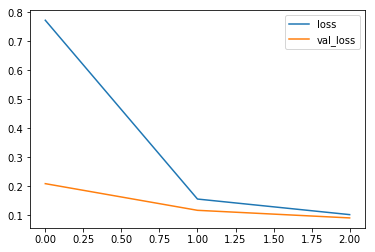

In [54]:

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

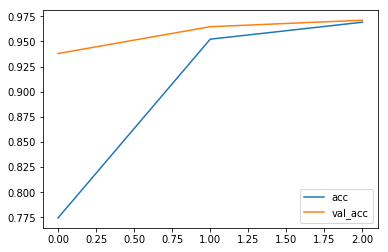

In [55]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()